In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
## specified input preprocess functions for each pretrained model, choose the right one to run
from tensorflow.keras.applications.vgg16 import preprocess_input
## from tensorflow.keras.applications.densenet import preprocess_input
## from tensorflow.keras.applications.resnet import preprocess_input 
import numpy as np
from scipy.spatial.distance import cosine
import pandas as pd

# Load pre-trained models
VGG16_model = VGG16(weights='imagenet', include_top=False)
ResNet_model = ResNet50(weights='imagenet', include_top=False)
Densenet121_model = DenseNet121(weights='imagenet', include_top=False)
middle_layer_model_resnet = Model(inputs=ResNet_model.input, outputs=ResNet_model.get_layer('conv3_block4_out').output)
middle_layer_model_densenet = Model(inputs=Densenet121_model.input, outputs=Densenet121_model.get_layer('conv4_block24_2_conv').output)
middle_layer_model_vgg = Model(inputs=VGG16_model.input, outputs=VGG16_model.get_layer('block3_conv3').output)

img_dir = 'COMP90086_2023_TLLdataset/test'
test_candidates = pd.read_csv('COMP90086_2023_TLLdataset/test_candidates.csv')

## VGG16: block5_conv3                  cos:0.51       eu:0.432
## ResNet50: conv5_block3_out           cos:0.548      eu:0.445
## Densenet121: 'conv5_block16_1_conv'  cos:0.518      eu:0.441
## VGG16: block4_conv3                  cos:0.18       eu:
## ResNet50: conv3_block3_out           cos:0.258      eu:
## Densenet121: 'conv4_block24_2_conv'  cos:0.298      eu:

def extract_features(img_name, side, base_model):
    """
    Given the path to an image, extract visual features using VGG16.
    """
    img_path = f"{img_dir}/{side}/{img_name}.jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = base_model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / np.linalg.norm(flattened_features)
    return normalized_features


In [2]:
def compute_similarities(feature_vec, all_features):
    """
    Compute cosine similarity between a feature vector and all features.
    """
    similarities = [1 - cosine(feature_vec, feat) for feat in all_features]
    return similarities


In [3]:
def compute_euclidean_distance(feature_vec, all_features):
    """
    Compute euclidean distance between a feature vector and all features.
    """
    similarities = [1/(1+np.linalg.norm(feature_vec - feat)) for feat in all_features]
    return similarities

In [4]:
# Extract features for all images
all_features = {}
for img_name in test_candidates["left"].unique():
    all_features[(img_name, "left")] = extract_features(img_name, "left", ResNet_model)
    
right_columns = [col for col in test_candidates.columns if col.startswith('c')]

# Extracting unique image names from all 'Right' columns
unique_right_images = pd.unique(test_candidates[right_columns].values.ravel('K'))

# Extracting features
for img_name in unique_right_images:
    all_features[(img_name, 'right')] = extract_features(img_name, 'right', ResNet_model)


# Compute similarities with cosine similarity
similarities = []

for _, row in test_candidates.iterrows():
    left_img_name = row['left']
    left_features = all_features[(left_img_name, 'left')]
    
    right_img_names = row.iloc[1:].values
    right_features = [all_features[(name, 'right')] for name in right_img_names]
    
    sim = compute_similarities(left_features, right_features)
    
    similarities.append([left_img_name] + sim)


# Compute similarities with euclidean distance
'''
similarities = []

for _, row in test_candidates.iterrows():
    left_img_name = row['left']
    left_features = all_features[(left_img_name, 'left')]
    
    right_img_names = row.iloc[1:].values
    right_features = [all_features[(name, 'right')] for name in right_img_names]
    
    sim = compute_euclidean_distance(left_features, right_features)
    
    similarities.append([left_img_name] + sim)

'''


1/1 [==============================] - 0s 420ms/step


In [6]:
# Create a DataFrame
columns = ['left'] + [f'c{i}' for i in range(20)]
similarity_df = pd.DataFrame(similarities, columns=columns)
similarity_df.to_csv('test-submission.csv', index=False)
similarity_df

,left,c0,c1,c2,c3,c4,c5,c6,c7,c8,...,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19
0,abm,0.445023,0.433346,0.446491,0.433481,0.424530,0.436487,0.429806,0.448751,0.437418,...,0.428398,0.436516,0.443650,0.445838,0.447097,0.435816,0.441408,0.429353,0.443365,0.431903
1,aci,0.434757,0.429758,0.431676,0.429266,0.432718,0.432325,0.426728,0.428217,0.427890,...,0.425380,0.434723,0.433719,0.429356,0.429945,0.429345,0.428118,0.433331,0.430960,0.437362
2,acn,0.428943,0.430140,0.426128,0.433959,0.433063,0.439899,0.433827,0.435214,0.428649,...,0.432125,0.426460,0.427579,0.433457,0.433161,0.436015,0.428695,0.433220,0.432519,0.435252
3,aco,0.457404,0.432567,0.431160,0.431380,0.433894,0.452425,0.439864,0.449273,0.430277,...,0.432394,0.425466,0.442709,0.433270,0.435565,0.430215,0.441900,0.433263,0.447707,0.442500
4,acu,0.445433,0.453185,0.440191,0.448093,0.444279,0.443910,0.423451,0.432138,0.428460,...,0.445953,0.431900,0.446280,0.440545,0.438795,0.437179,0.438140,0.442390,0.436845,0.427587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,zyc,0.477984,0.429009,0.453603,0.434566,0.427459,0.441222,0.436461,0.428937,0.432328,...,0.432748,0.431590,0.428122,0.424273,0.426225,0.431265,0.425500,0.435911,0.426607,0.437891
1996,zyi,0.439625,0.427755,0.454987,0.429756,0.430429,0.430518,0.443746,0.430542,0.428583,...,0.431134,0.435067,0.436975,0.428856,0.431667,0.441845,0.433128,0.439894,0.438190,0.438272
1997,zym,0.444304,0.429458,0.454680,0.474581,0.441075,0.459034,0.455453,0.441265,0.434880,...,0.428390,0.468418,0.458101,0.438200,0.451968,0.451728,0.432753,0.452902,0.434210,0.457571
1998,zzq,0.432520,0.468632,0.458684,0.442903,0.450849,0.438760,0.450439,0.432974,0.441644,...,0.437357,0.437772,0.436677,0.448574,0.432015,0.452694,0.433591,0.442019,0.444416,0.441635


Result Plot

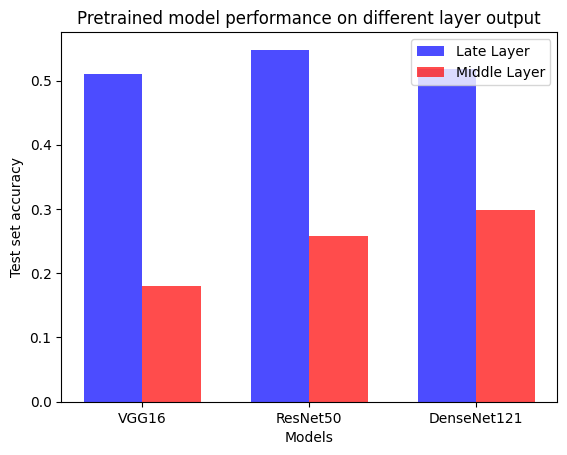

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['VGG16', 'ResNet50', 'DenseNet121']
late_layer_accuracy = [0.51, 0.548, 0.518]
middle_layer_accuracy = [0.18, 0.258, 0.298]

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
index = np.arange(len(models))

# Create the first set of bars
plt.bar(index, late_layer_accuracy, bar_width, label='Late Layer', color='b', alpha=0.7)

# Create the second set of bars
plt.bar(index + bar_width, middle_layer_accuracy, bar_width, label='Middle Layer', color='r', alpha=0.7)

# Label the x-axis
plt.xlabel('Models')
plt.xticks(index + bar_width / 2, models)

# Label the y-axis
plt.ylabel('Test set accuracy')

# Set the title
plt.title('Pretrained model performance on different layer output')

# Add a legend
plt.legend()

# Show the plot
plt.show()
